In [1]:
%load_ext autoreload

In [2]:
from generative.networks.nets import VQVAE
from generative.networks.layers.vector_quantizer import VectorQuantizer

/home/durga/Hw4/hw4/lib/python3.8/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/durga/Hw4/hw4/lib/python3.8/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [3]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
from PIL import Image
import torchmetrics
import pytorch_lightning as pl

from generative.networks.nets import VQVAE
from generative.networks.layers.vector_quantizer import VectorQuantizer

from monai.data import DataLoader as MONAI_DataLoader, Dataset as MONAI_Dataset
from monai.transforms import  Compose, EnsureChannelFirst, NormalizeIntensity, Resize, CenterSpatialCrop
from torch.utils.data import random_split
from monai.data import MetaTensor

In [4]:
class VQVAE_Lightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        AFFINE = "AFFINE"
        EMA = "EMA"
        QUANT_TYPE = EMA
        LOWER_COMPRESSION = True
        CONDITIONAL = False
        
        downsample_parameters = ((2, 4, 1, 1), (2, 4, 1, 1))
        
        upsample_parameters = ((2, 4, 1, 1, 0), (2, 4, 1, 1, 0))
    
        # Initialize base VQVAE model with correct parameter names
        self.vqvae = VQVAE(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
                num_res_layers=2,
                downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
                upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
                num_channels=(256, 256),
                num_res_channels=(256, 256),
                num_embeddings=256,
                embedding_dim=32,
            )
        
        if QUANT_TYPE == AFFINE:
            self.vqvae.quantizer = VectorQuantizer(
                AffineVectorQuantizer(
                    spatial_dims=self.vqvae.spatial_dims,
                    num_embeddings=self.vqvae.num_embeddings,
                    embedding_dim=self.vqvae.embedding_dim,
                    replace_freq=20,
                    kmeans_init=True,
                    affine_groups=8
                )
            )

        self.vqvae = self.vqvae.cuda()
        if LOWER_COMPRESSION:
            self.vqvae.encoder.blocks[3] = torch.nn.Identity()
            self.vqvae.decoder.blocks[3] = torch.nn.Identity()
        
        # Metrics
        self.train_mse = torchmetrics.MeanSquaredError()
        self.val_mse = torchmetrics.MeanSquaredError()

        
        self.learning_rate = 1e-5
        self.VQVAE_SAVE_PATH = 'vqvae_ema.pt' if QUANT_TYPE == EMA else 'vqvae_affine.pt'


    def forward(self, x):
        # Ensure x is a tensor
        return self.vqvae(x)


    def training_step(self, batch, batch_idx):
        self.vqvae.train() 
        x,_ = batch
        recon_x, quant_loss = self(x)
        
        # Reconstruction loss
        recon_loss = F.mse_loss(recon_x, x)
        
        # Total loss
        total_loss = recon_loss + quant_loss
        
        
        self.log('train_loss', total_loss)
        self.log('train_recon_loss', recon_loss)
        self.log('train_quant_loss', quant_loss)
        
        
        return total_loss

    def validation_step(self, batch, batch_idx):
        self.vqvae.eval()
        x,_ = batch
        recon_x, quant_loss = self(x)
        
        recon_loss = F.mse_loss(recon_x, x)
        total_loss = recon_loss + quant_loss
        
        
        self.log('val_loss', total_loss)
        self.log('val_recon_loss', recon_loss)
        self.log('val_quant_loss', quant_loss)
        return total_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate,weight_decay=1e-6 )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True,min_lr=1e-6
        )
        return {
           "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            },
        }

In [5]:
model = VQVAE_Lightning()

In [6]:
import torchinfo
torchinfo.summary(model.vqvae, input_size=(1,3,224,224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                        Output Shape              Param #
VQVAE                                         [1, 3, 224, 224]          --
+ Encoder: 1-1                                [1, 32, 112, 112]         --
|    + ModuleList: 2-1                        --                        --
|    |    + Convolution: 3-1                  [1, 256, 112, 112]        12,544
|    |    + VQVAEResidualUnit: 3-2            [1, 256, 112, 112]        1,180,160
|    |    + VQVAEResidualUnit: 3-3            [1, 256, 112, 112]        1,180,160
|    |    + Identity: 3-4                     [1, 256, 112, 112]        --
|    |    + VQVAEResidualUnit: 3-5            [1, 256, 112, 112]        1,180,160
|    |    + VQVAEResidualUnit: 3-6            [1, 256, 112, 112]        1,180,160
|    |    + Convolution: 3-7                  [1, 32, 112, 112]         73,760
+ VectorQuantizer: 1-2                        --                        --
|    + EMAQuantizer: 2-2                      [1, 32, 112, 

In [12]:
import torch.nn.functional as F

In [13]:
class CustomImageFolderDataset(MONAI_Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = []  # List to store (image_path, label) pairs
        self.classes = os.listdir(root)
        
        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root, class_name)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_file)
                    self.data.append((img_path, idx))  # (image path, class label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)  # Open the image using PIL
        image = image.convert("RGB")
        image = np.array(image)
        image = image/255
        meta_tensor = MetaTensor(image,
            meta={
                "spatial_shape": image.shape[:-1],  # H, W
                "original_channel_dim": -1  # Explicitly specify channel dimension
            }
        )
        if self.transform:
            transformed_image = self.transform(meta_tensor) 
        return transformed_image, label

In [14]:
transform = Compose([
    EnsureChannelFirst(channel_dim=-1),  # Specify the input channel dimension
    Resize(
        spatial_size=(256, 256),  # Height, Width
        mode="bilinear",
        align_corners=False
    ),
    CenterSpatialCrop(roi_size=(224, 224)),  # Height, Width
])

train_dataset = CustomImageFolderDataset(root='/home/dl_class/data/NEA/NEUdata_split/Train', transform=transform)

# Optionally split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [1200, 420])

In [15]:
num_workers = min(31, os.cpu_count() or 1)  # Fallback to 1 if cpu_count returns None
batch_size= 16 
num_epochs = 50
# DataLoaders
train_dataloader = MONAI_DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True  # Keep workers alive between epochs
)

val_dataloader = MONAI_DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

# Calculate appropriate logging interval
num_train_batches = len(train_dataloader)
log_every_n_steps = min(10, num_train_batches // 4)  # Log at least 4 times per epoch

In [16]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary

In [17]:
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=num_epochs,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    log_every_n_steps=log_every_n_steps,
    deterministic=False,
    precision=32,
    gradient_clip_val=0.5,  # Add gradient clipping
    gradient_clip_algorithm='norm',  # Use norm-based clipping
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints',
            filename='vqvae-{epoch:02d}-{val_loss:.2f}',
            save_top_k=3,
            mode='min',
            save_last=True,
        ),
        pl.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min',
            verbose=False,
            min_delta=1e-4  # Minimum change to qualify as an improvement
        ),
    ],
    logger=pl.loggers.TensorBoardLogger('logs/', name='vqvae_neu')
)

# Train model
trainer.fit(model, train_dataloader, val_dataloader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode
------------------------------------------------------
0 | vqvae     | VQVAE            | 9.6 M  | eval
1 | train_mse | MeanSquaredError | 0      | eval
2 | val_mse   | MeanSquaredError | 0      | eval
------------------------------------------------------
9.6 M     Trainable params
8.2 K     Non-trainable params
9.6 M     Total params
38.488    Total estimated model params size (MB)
0         Modules in train mode
86        Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:24<00:00,  3.01it/s, v_num=1]
Validation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:24<00:00,  3.00it/s, v_num=1]
Validation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [18]:
test_dataset = CustomImageFolderDataset(root='/home/dl_class/data/NEA/NEUdata_split/Test', transform=transform)

In [19]:
test_dataloader = MONAI_DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

In [20]:
def get_reconstruction(model, test_dataset, device):
    model.eval()  # Ensure the model is in evaluation mode
    num_reconstructions = 50  # Number of reconstructions to generate
    random_indices = random.sample(range(len(test_dataset)), num_reconstructions)
    
    reconstructed_images = []
    original_images = []
    original_labels = []

    # Move model to the correct device (GPU or CPU)
    model.to(device)

    for idx in random_indices:
        img, label = test_dataset[idx]
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        with torch.no_grad():  # Disable gradient tracking
            recon_x, _ = model(img)  # Get the reconstructed image (quant_loss is ignored here)
        
        # Store the results
        reconstructed_images.append(recon_x.cpu().squeeze())  # Move to CPU and remove batch dimension
        original_images.append(img.cpu().squeeze())  # Move to CPU and remove batch dimension
        original_labels.append(label)  # Store the label

    return reconstructed_images, original_images, original_labels


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reconstructed_images, original_images, original_labels = get_reconstruction(model, test_dataloader.dataset, device)

In [23]:
pip install torchvision

     |████████████████████████████████| 7.0 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [24]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
from tqdm import tqdm


classifier = resnet18(weights=ResNet18_Weights.DEFAULT)
num_classes = len(test_dataset.classes)
classifier.fc = nn.Linear(classifier.fc.in_features, num_classes)
classifier.to(device)

classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 30

progress_bar = tqdm(range(num_epochs), desc=f'Epoch 0/{num_epochs}')

for epoch in progress_bar:
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        classifier_optimizer.zero_grad()
        outputs = classifier(images)
        loss = classifier_criterion(outputs, labels)
        loss.backward()
        classifier_optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = 100 * correct / total
    
    # Update progress bar with epoch count and metrics
    progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    progress_bar.set_postfix({
        'loss': f'{epoch_loss:.4f}',
        'acc': f'{epoch_acc:.2f}%'
    })


Epoch 3/30:  10%|█████████████▊                                                                                                                            | 3/30 [00:04<00:42,  1.58s/it, loss=0.2776, acc=90.58%]


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:46<00:00,  1.54s/it, loss=0.0422, acc=98.92%]


In [30]:
pip install matplotlib

     |████████████████████████████████| 9.2 MB 7.8 MB/s eta 0:00:01
  Using cached importlib_resources-6.4.5-py3-none-any.whl (36 kB)
     |████████████████████████████████| 4.7 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 11.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import matplotlib.pyplot as plt

In [32]:
def plot_reconstruction(reconstructed_images,original_images):
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(original_images[i].permute(1, 2, 0).clip(0,1))
        axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0).clip(0,1))
    plt.show()

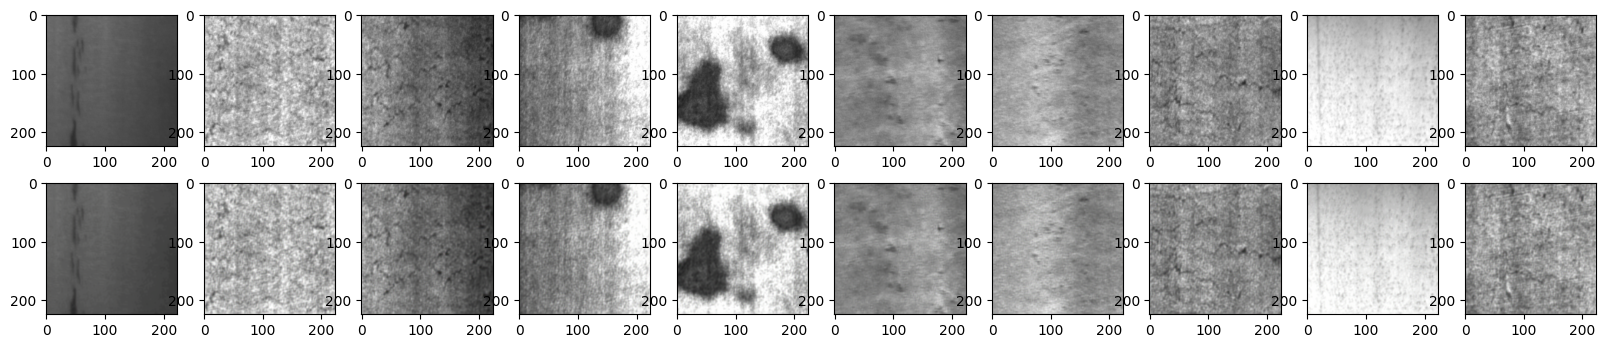

In [33]:
plot_reconstruction(reconstructed_images,original_images)

In [34]:
def compare_reconstruction_orginal(classifier,reconstructed_images,original_images,original_labels):
    classifier.eval()
    or_correct = 0
    re_correct = 0
    
    with torch.no_grad():
        i=0
        for re_image, or_image in zip(reconstructed_images,original_images):
            re_image = re_image.unsqueeze(0)
            or_image = or_image.unsqueeze(0)
            re_outputs = classifier(re_image.to(device))
            or_outputs = classifier(or_image.to(device))
            _, re_predicted = re_outputs.max(1)
            _, or_predicted = or_outputs.max(1)
            
            or_correct += or_predicted.eq(original_labels[i]).sum().item()
            re_correct += re_predicted.eq(original_labels[i]).sum().item()
            
            i=i+1
    
    or_test_acc = 100 * or_correct / len(reconstructed_images)
    re_test_acc = 100 * re_correct / len(reconstructed_images)
    
    print(f"Test Accuracy on Reconstructed NEU Data: {re_test_acc:.2f}% Text Accuracy on the same orginal images is {or_test_acc:.2f}% " )

In [35]:
compare_reconstruction_orginal(classifier,reconstructed_images,original_images,original_labels)

Test Accuracy on Reconstructed NEU Data: 98.00% Text Accuracy on the same orginal images is 98.00% 


**Note: The accuracy on reconstruction data is very high 98 \% which ie very close to the orginal data**